### Manifold learning

Study the Tutorial tutorial_manifold_tSNE and the tutorial_manifold_spectral_clustering and the Study_Case_pipeline. Next improve the code by comparing the performance of k-means and spectral clustering. Also compare PCA and t-SNE in the visualization of the result. You can use the pipeline function of scikit-learn and hyperparameter tuning with GridSearchCV. Here's a possible approach:

- Load the dataset to be used for the clustering analysis.
- Preprocess the dataset as needed (e.g., scale the features, normalize the data, etc.).
- Define a pipeline with preprocessing and clustering
- use PCA and t-SNE for dimension reduction and visualize the dimensions, use the clusters to color the datapoints
- use GridSearchCV to optimize the hyper parameters
- Evaluate the performance of the models using a suitable metric
- choose the best cluster method and the best visualization method combination

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

### Load data

In [2]:
#  load data
brain_data = pd.read_csv("../Data/Brain_GSE50161.csv")
# Drop a samples column
brain_data = brain_data.drop('samples', axis=1)

### Explore_data

In [3]:
brain_data.shape

(130, 54676)

In [4]:
# cheke a uique value in type columns
unique_value = brain_data['type'].unique()
unique_value

array(['ependymoma', 'glioblastoma', 'medulloblastoma', 'normal',
       'pilocytic_astrocytoma'], dtype=object)

In [5]:
datatypes = brain_data['type'].value_counts()
# Get the unique names
unique_names = datatypes.index

unique_names

Index(['ependymoma', 'glioblastoma', 'medulloblastoma',
       'pilocytic_astrocytoma', 'normal'],
      dtype='object')

In [6]:
#check for zero values
zero_value = brain_data.eq(0).sum().sum()
zero_value

0

In [7]:
brain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Columns: 54676 entries, type to AFFX-TrpnX-M_at
dtypes: float64(54675), object(1)
memory usage: 54.2+ MB


## Preprocess the dataset as needed 

### Extract the features

In [8]:
# extract the target
targets =brain_data['type']
# Remove any non-numeric columns from the dataset(extract the features)
features = brain_data.select_dtypes(include=[float, int])

### check for skewness

In [9]:
skewness =features .skew()
highly_skewed_count = 0
approximately_symmetric_count = 0

# Count the number of columns in each skewness category
for skewness_value in skewness:
    if skewness_value < 0.75:
        highly_skewed_count += 1
    else:
        approximately_symmetric_count += 1

print(f"Number of highly skewed columns: {highly_skewed_count}")
print(f"Number of approximately symmetric columns: {approximately_symmetric_count}")

Number of highly skewed columns: 41304
Number of approximately symmetric columns: 13371


### Transform the data

In [11]:
# perform log transformation on skewed_columns
skew_columns = (features.skew().sort_values(ascending = False))
skew_columns = skew_columns[skew_columns > 0.75]
for col in skew_columns.index.tolist():
   features[col] = np.log1p(features[col])

log transformation transforms skewed distribution to a normal distribution. log transformation is not able to log 0 or negative values so we should add a constant to all value to ensure values > 1 

### scaling

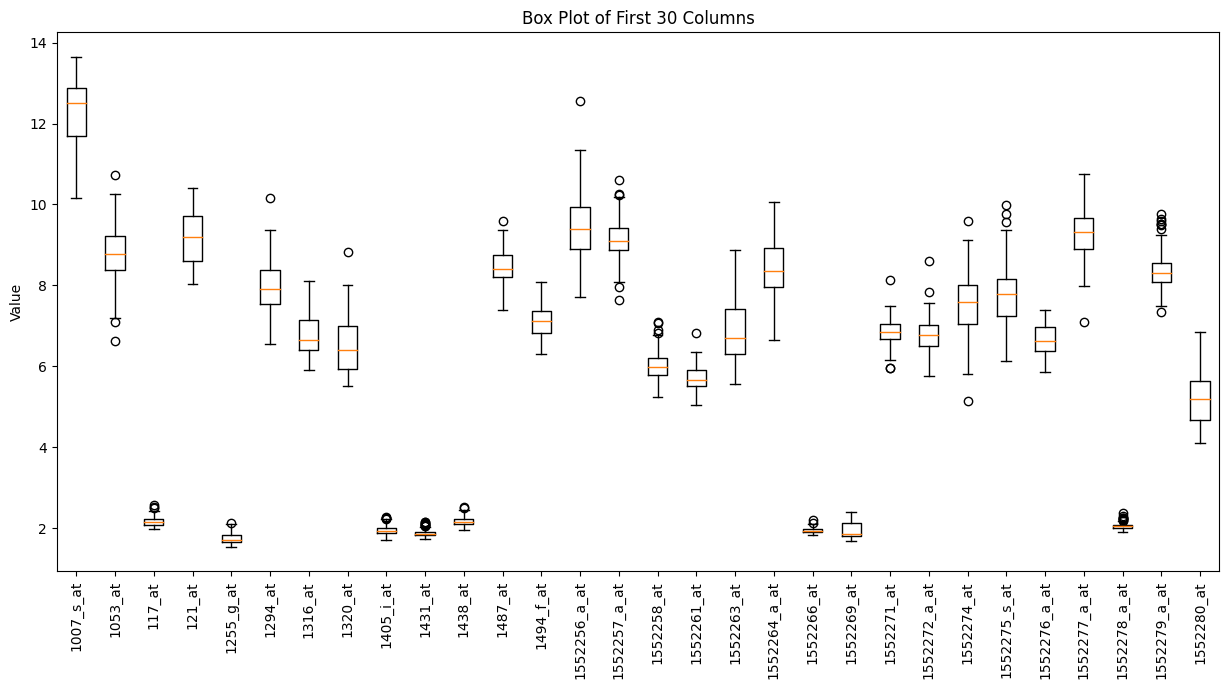

In [12]:
import matplotlib.pyplot as plt

# Create a figure and axes for the box plots
fig, ax = plt.subplots(figsize=(15, 7))

# Select the first 30 columns from your dataset
selected_columns = features.columns[:30]

# Create a box plot for the selected columns
plt.boxplot(features[selected_columns])

# Set the x-axis tick labels
plt.xticks(range(1, len(selected_columns) + 1), selected_columns, rotation='vertical')

# Set the y-axis label
plt.ylabel('Value')

# Set the plot title
plt.title('Box Plot of First 30 Columns')

# Display the plot
plt.show()

as we can see in the plot of the first 30 columns the features are not in the same scale and we need to scale the data

In [13]:
sc = StandardScaler()
scaled_features = sc.fit(features).transform(features)

# visualization with t-SNE


#### dimension reduction using t-sne ans PCA

In [85]:
def perform_clustering_clustering(data, n_pca_components=50, n_tsne_components=2):
     
    """
    Perform PCA and t-SNE dimension reduction on the input data.

    Args:
        data: The input data to perform dimension reduction on.
        n_pca_components (optional): The number of components to keep in the PCA step.
            Defaults to 50 if not provided.
        n_tsne_components (optional): The number of components to keep in the t-SNE step.
            Defaults to 2 if not provided.

    Returns:
        A tuple of PCA and t-SNE results: (pca_result, tsne_result).
    """
        
    # Perform PCA for dimension reduction
    pca = PCA(n_components=n_pca_components)
    pca_result = pca.fit_transform(data)

    # Perform t-SNE for further dimension reduction
    tsne = TSNE(n_components=n_tsne_components, random_state=0, method='barnes_hut')
    tsne_result = tsne.fit_transform(data)

    return pca_result, tsne_result

In [87]:
# call  function perform_clustering_clusterin
pca_result, tsne_result = perform_clustering_clustering(scaled_features)

In [88]:
#Create a DataFrame of results
results = pd.DataFrame({
'PCA1': pca_result[:, 0],
'PCA2': pca_result[:, 1],
't-SNE1': tsne_result[:, 0],
't-SNE2': tsne_result[:, 1],    
})

def plot_results(results, targets):
    """
Plot the results of dimension reduction using scatter plots.

Args:
    results: The DataFrame containing the dimension reduction results (PCA and t-SNE).
    targets: The target variable used to color the scatter plots.

Returns:
    plot
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='PCA1', y='PCA2', hue=targets, data=results, palette='Set1')
    plt.title('PCA')
    plt.legend(title='Target', loc='best')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='t-SNE1', y='t-SNE2', hue=targets, data=results, palette='Set1')
    plt.title('t-SNE')
    plt.legend(title='Target', loc='best')

    plt.tight_layout()
    plt.show()

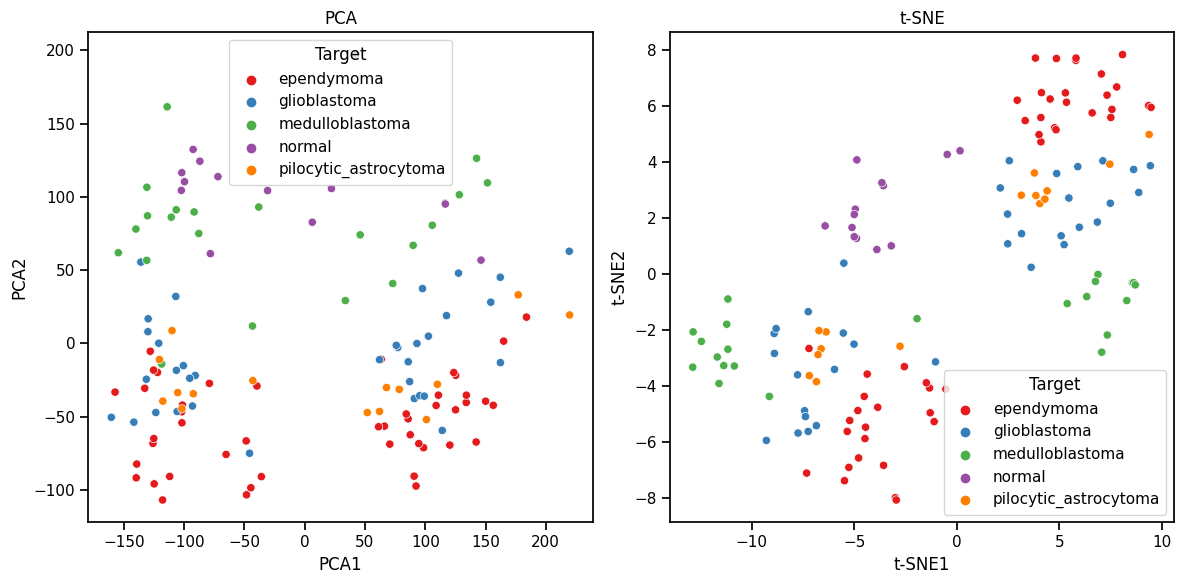

In [89]:
plot_results(results, targets)

## Hyperparameter
Hyperparameters are parameters that are set before the learning process begins and control the behavior of a learning algorithm. They determine the values of model parameters that the learning algorithm will learn during training. Hyperparameters are not learned from the data but are chosen by the user or determined through a search process https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac.

#### visualization with differnt range of perplexities(hyperparameter) for T_SNE  with out appliying PCA dimension reduction, kmean clustering

In [74]:

def plot_tsne_perplexity(data, targets, perplexities=[5, 10, 20, 30, 40, 50]):

    """
    Plot t-SNE results for different perplexity values.

    Args:
        data: The input data to perform t-SNE on.
        targets: Target variable for coloring the scatter plots.
        perplexities: A list of perplexity values to iterate over.
            Defaults to [5, 10, 20, 30, 40, 50] if not provided.

    Returns:
        plot
    """

    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Perplexity', 't-SNE1', 't-SNE2', 'Target'])

    # Iterate over perplexity values
    for perplexity in perplexities:
        # Create a t-SNE instance with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity)

        # Fit and transform the features
        tsne_result = tsne.fit_transform(data)

        # Append the results to the DataFrame
        df = pd.DataFrame({
            'Perplexity': perplexity,
            't-SNE1': tsne_result[:, 0],
            't-SNE2': tsne_result[:, 1],
            'Target': targets
        })
        results = pd.concat([results, df], ignore_index=True)

    # Plot t-SNE results for each perplexity
    plt.figure(figsize=(12, 6))
    for i, perplexity in enumerate(perplexities):
        plt.subplot(2, 3, i+1)
        subset = results[results['Perplexity'] == perplexity]
        sns.scatterplot(x='t-SNE1', y='t-SNE2', data=subset, hue='Target', palette='Set1', legend=False)
        plt.title(f"Perplexity = {perplexity}")

    # Show a single legend label for the whole plot
    plt.tight_layout()
    sns.set_context('notebook')
    plt.show()

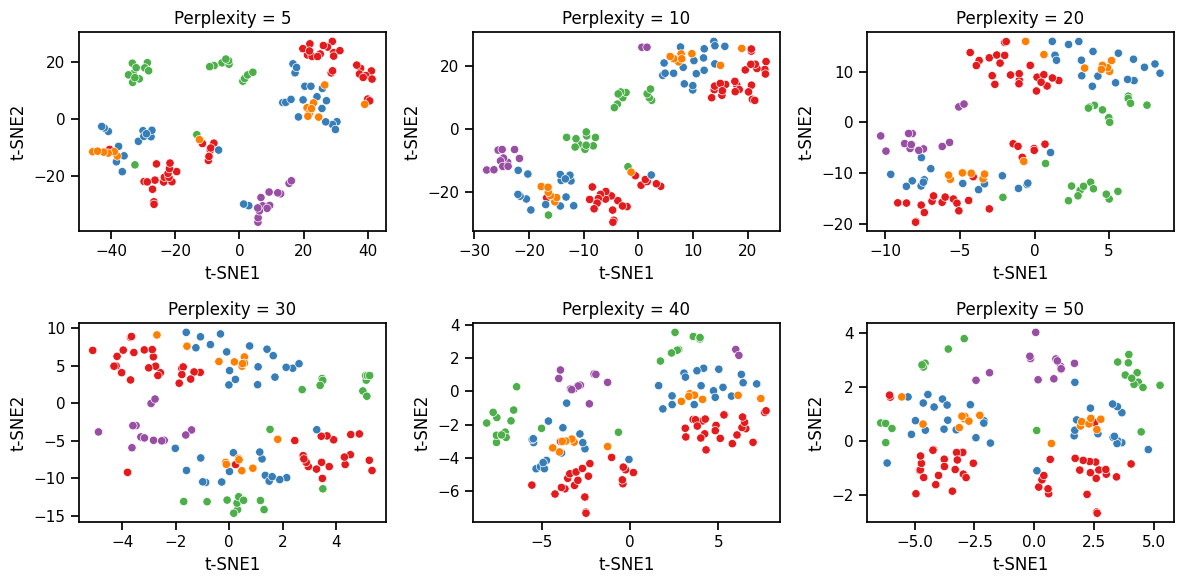

In [75]:
plot_tsne_perplexity(scaled_features, targets)

#### PCA and T_SNE dimension reduction and kmean clustering with differnt range of perplexities for TSNE

In [76]:
def plot_kmean_tsne(data, n_pca_components=50, n_clusters=5, perplexities=[5, 10, 20, 30, 40, 50]):

    """
    Perform K-means clustering on PCA-transformed data and plot t-SNE results for different perplexity values.

    Args:
        data: The input data to perform K-means clustering and t-SNE on.
        n_pca_components : The number of components to keep in the PCA step. Defaults to 50 if not provided.
        n_clusters: The number of clusters to create using K-means clustering. Defaults to 5 if not provided.
        perplexities: A list of perplexity values to iterate over in t-SNE. Defaults to [5, 10, 20, 30, 40, 50] if not provided.

    Returns:
        plot
    """

    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=n_pca_components)
    pca_result = pca.fit_transform(data)

    # Perform clustering using K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_result)

    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Perplexity', 't-SNE1', 't-SNE2', 'Cluster'])

    # Iterate over perplexity values
    for perplexity in perplexities:
        # Create a t-SNE instance with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity)

        # Fit and transform the features
        tsne_result = tsne.fit_transform(pca_result)

        # Append the results to the DataFrame
        df = pd.DataFrame({
            'Perplexity': perplexity,
            't-SNE1': tsne_result[:, 0],
            't-SNE2': tsne_result[:, 1],
            'Cluster': cluster_labels
        })
        results = pd.concat([results, df], ignore_index=True)

    # Plot t-SNE results for each perplexity
    plt.figure(figsize=(12, 6))
    for i, perplexity in enumerate(perplexities):
        plt.subplot(2, 3, i+1)
        subset = results[results['Perplexity'] == perplexity]
        sns.scatterplot(x='t-SNE1', y='t-SNE2', data=subset, hue='Cluster', palette='Set1', legend=False)
        plt.title(f"Perplexity = {perplexity}")

    # Show a single legend label for the whole plot
    plt.tight_layout()
    sns.set_context('notebook')
    plt.show()

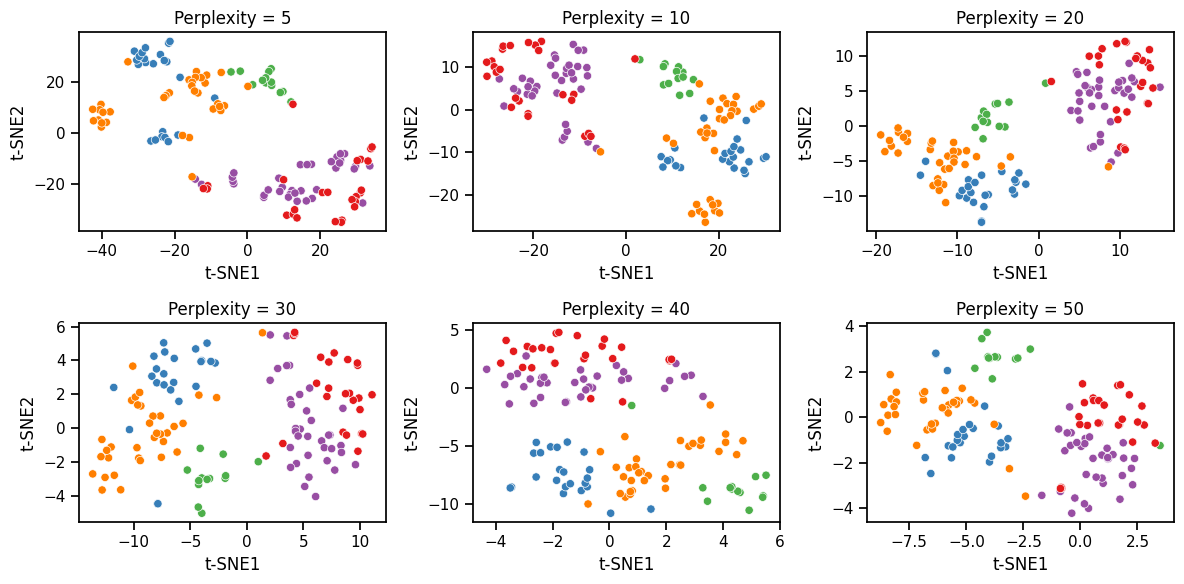

In [52]:
plot_kmean_tsne(data=scaled_features)

#### PCA and T_SNE dimension reduction with differnt range of n_inits for kmean clustering

In [77]:
def plot_tsne_perplexity_ninit(data, n_pca_components=50, perplexities=[5, 10, 20, 30, 40, 50], n_inits=[10, 20, 30]):
    """
    Perform PCA to reduce dimensionality, apply t-SNE with different perplexity and different n_init values for kmean clustring,
    and plot the t-SNE results for each combination of perplexity and n_init.

    Args:
        data: The input data to perform PCA, t-SNE, and K-means clustering on.
        n_pca_components: The number of components to keep in the PCA step. Defaults to 50 if not provided.
        perplexities: A list of perplexity values to iterate over in t-SNE. Defaults to [5, 10, 20, 30, 40, 50] if not provided.
        n_inits: A list of n_init values to iterate over in K-means clustering. Defaults to [10, 20, 30] if not provided.

    Returns:
        plot
    """
    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=n_pca_components)
    pca_result = pca.fit_transform(data)

    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Perplexity', 'n_init', 't-SNE1', 't-SNE2', 'Cluster'])

    # Iterate over perplexity and n_init values
    for perplexity in perplexities:
        for n_init in n_inits:
            # Create a t-SNE instance with the current perplexity value
            tsne = TSNE(n_components=2, perplexity=perplexity)

            # Fit and transform the features
            tsne_result = tsne.fit_transform(pca_result)

            # Perform clustering using K-means with the current n_init value
            kmeans = KMeans(n_clusters=5, n_init=n_init)
            cluster_labels = kmeans.fit_predict(pca_result)

            # Append the results to the DataFrame
            df = pd.DataFrame({
                'Perplexity': perplexity,
                'n_init': n_init,
                't-SNE1': tsne_result[:, 0],
                't-SNE2': tsne_result[:, 1],
                'Cluster': cluster_labels
            })
            results = pd.concat([results, df], ignore_index=True)

    # Plot t-SNE results for each perplexity and n_init combination
    plt.figure(figsize=(15, 20))
    for i, perplexity in enumerate(perplexities):
        for j, n_init in enumerate(n_inits):
            plt.subplot(len(perplexities), len(n_inits), i * len(n_inits) + j + 1)
            subset = results[(results['Perplexity'] == perplexity) & (results['n_init'] == n_init)]
            sns.scatterplot(x='t-SNE1', y='t-SNE2', data=subset, hue='Cluster', palette='Set1', legend=False)
            plt.title(f"Perplexity = {perplexity}, n_init = {n_init}")

    # Show a single legend label for the whole plot
    plt.tight_layout()
    sns.set_context('notebook')
    plt.show()

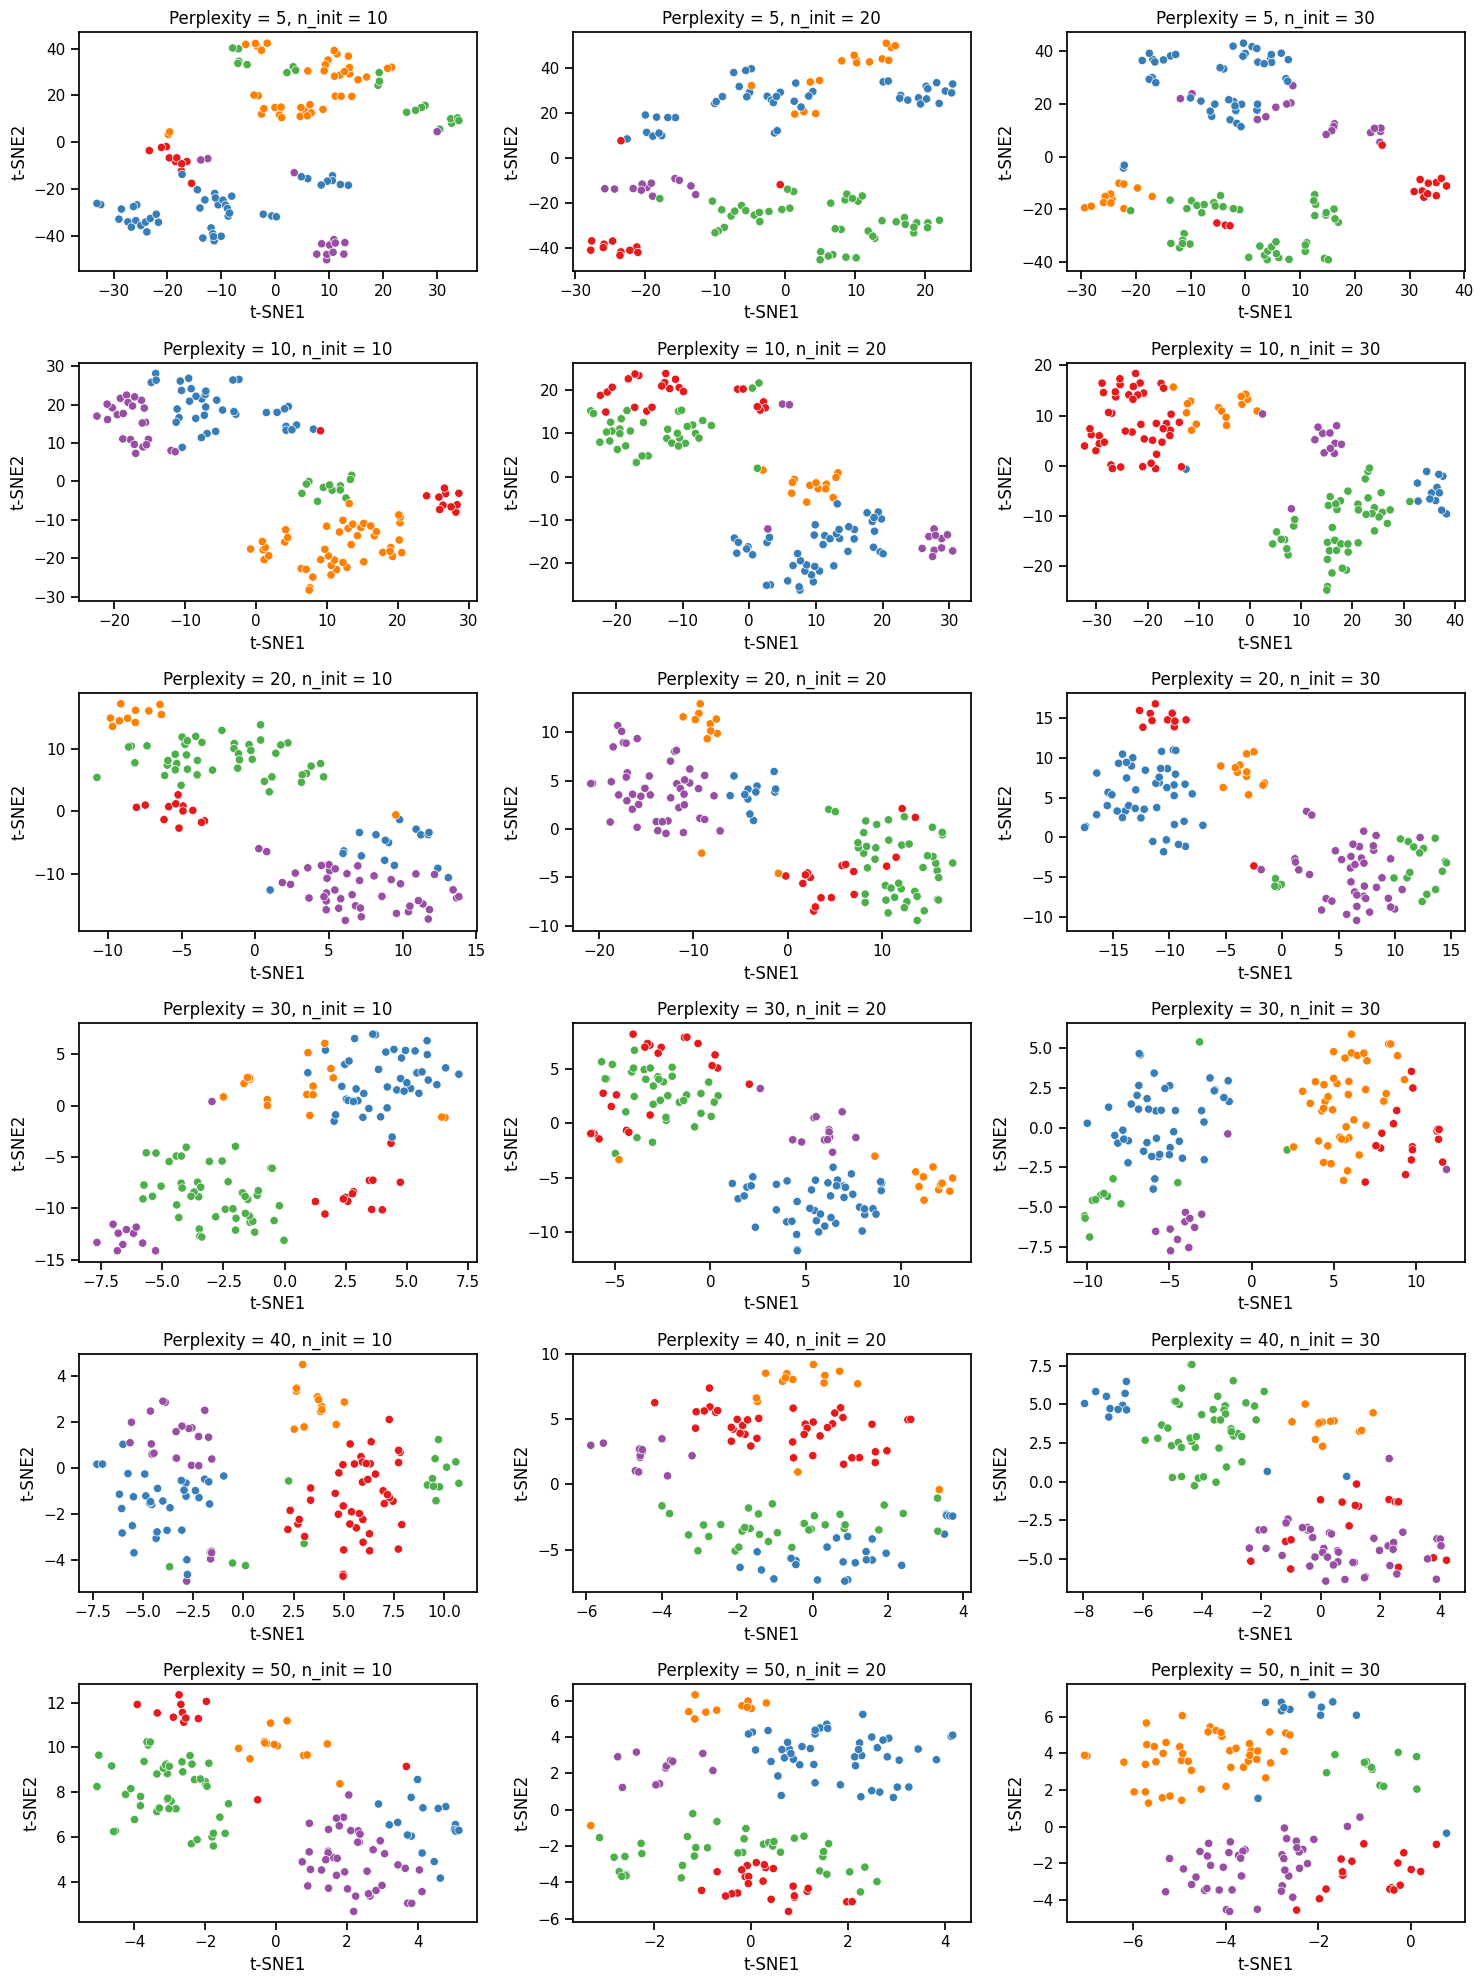

In [78]:
plot_tsne_perplexity_ninit(data=scaled_features)

## Finding the best hyperparameters for the K-means clustering algorithm applied to t-SNE embeddings


In [60]:
# Perform t-SNE to get embeddings
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(scaled_features)

# Define the parameter grid for grid search
param_grid = {
    'n_clusters': [3, 4, 5],
    'n_init': [10, 20, 30]
}
# Instantiate KMeans object
kmeans = KMeans()

# Create GridSearchCV object with silhouette_score as the scoring metric
grid_search = GridSearchCV(
    estimator=kmeans, 
    param_grid=param_grid,
    cv=5,  # default 3-fold cross-validation
    n_jobs=5,
    verbose=1 #Controls the verbosity: the higher, the more messages.
)

# Fit GridSearchCV to the t-SNE embeddings
grid_search.fit(tsne_result)

# Retrieve the best hyperparameter values and corresponding score
best_params = grid_search.best_params_

# Print the best hyperparameters and score
print("Best number of clusters:", best_params['n_clusters'])
print("Best number of initializations:", best_params['n_init'])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best number of clusters: 5
Best number of initializations: 10


The first line of the output indicats search is being performed with 5-fold cross-validation and a total of 9 different combinations of hyperparameters. and accourding to this result 5 numbres of cluster and 10 initalization(Number of times the k-means algorithm is run with different centroid seeds) are the best parameters.https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#### PCA and T_SNE dimension reduction with differnt range of gammas for  SpectralClustering clustering

In [61]:

def plot_tsne_perplexity_gamma(data, targets, n_pca_components=50, perplexities=[5, 10, 20, 30, 40, 50], gammas=[0.1, 0.5, 1, 5, 10]):
    """
    Perform PCA to reduce dimensionality, apply t-SNE with different perplexity and gamma values,
    perform spectral clustering, and plot the t-SNE results for each combination of perplexity and gamma.

    Args:
        data: The input data to perform PCA, t-SNE, and spectral clustering on.
        targets: The target labels for the data.
        n_pca_components : The number of components to keep in the PCA step. Defaults to 50 if not provided.
        perplexities : A list of perplexity values to iterate over in t-SNE. Defaults to [5, 10, 20, 30, 40, 50] if not provided.
        gammas : A list of gamma values to iterate over in spectral clustering. Defaults to [0.1, 0.5, 1, 5, 10] if not provided.

    Returns:
        plot
    """
    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=n_pca_components)
    pca_result = pca.fit_transform(data)

    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['Perplexity', 'Gamma', 't-SNE1', 't-SNE2', 'Target'])

    # Iterate over perplexity and gamma values
    for perplexity in perplexities:
        for gamma in gammas:
            # Create a t-SNE instance with the current perplexity value
            tsne = TSNE(n_components=2, perplexity=perplexity)

            # Fit and transform the features
            tsne_result = tsne.fit_transform(pca_result)

            # Perform spectral clustering
            spectral = SpectralClustering(n_clusters=5, gamma=gamma)
            cluster_labels = spectral.fit_predict(pca_result)

            # Append the results to the DataFrame
            df = pd.DataFrame({
                'Perplexity': perplexity,
                'Gamma': gamma,
                't-SNE1': tsne_result[:, 0],
                't-SNE2': tsne_result[:, 1],
                'Target': targets
            })
            results = pd.concat([results, df], ignore_index=True)

    # Plot t-SNE results for each perplexity and gamma combination
    plt.figure(figsize=(15, 20))
    for i, perplexity in enumerate(perplexities):
        for j, gamma in enumerate(gammas):
            plt.subplot(len(perplexities), len(gammas), i * len(gammas) + j + 1)
            subset = results[(results['Perplexity'] == perplexity) & (results['Gamma'] == gamma)]
            sns.scatterplot(x='t-SNE1', y='t-SNE2', data=subset, hue='Target', palette='Set1', legend=False)
            plt.title(f"Perplexity = {perplexity}, Gamma = {gamma}")

    # Show a single legend label for the whole plot
    plt.tight_layout()

    # Plot the pairplot visualization
    sns.set_context('notebook')
    plt.show()

c:\Users\Hallo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Hallo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:430: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
c:\Users\Hallo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Hallo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:430: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
c:\Users\Hal

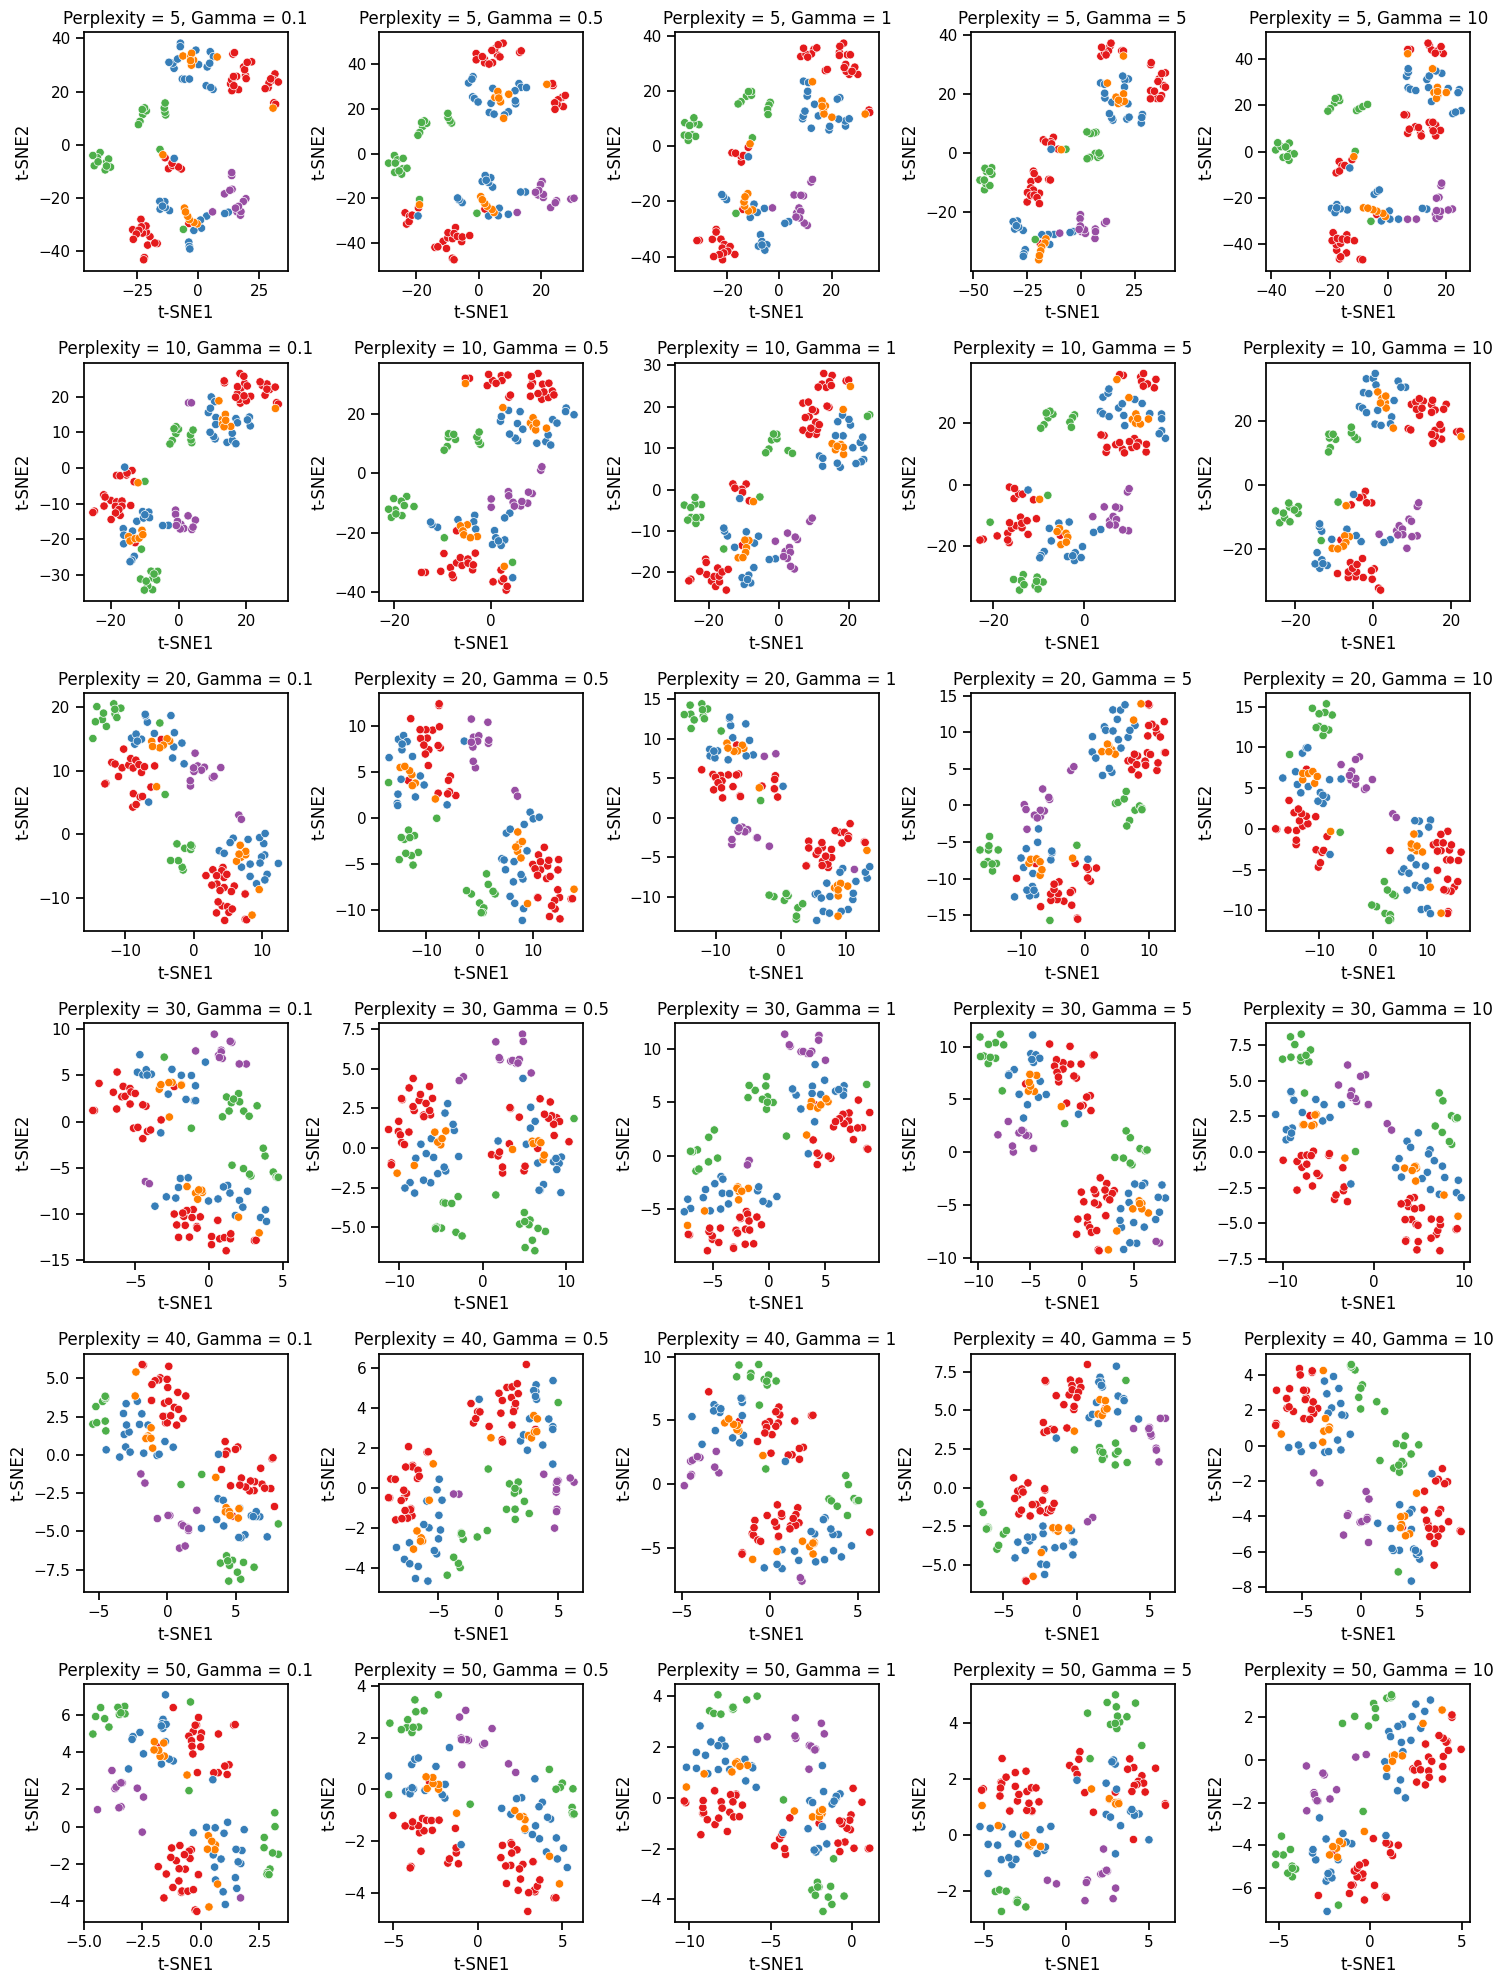

In [62]:
plot_tsne_perplexity_gamma(scaled_features, targets)

## kmean and SpectralClustering Clustering Performance Evaluation Metrics

#### Most popular evaluation metrics for clustering algorithms are the Silhouette coefficient, calinski_harabasz_score and davies_bouldin_score

The Silhouette score measures the quality of clustering,by  calculates the average distance between the sample and all other points within the same cluster inaddition it computes the average distance between the sample and all points in the nearest neighboring cluster. values closer to +1 indicating dense and well-separated clusters, values around 0 suggesting overlapping clusters, and values closer to -1 indicating incorrect clustering.

Calinski_harabasz_score calculates the ratio of the sum of between-clusters dispersion to the sum of within-cluster dispersion for all clusters. A high Calinski-Harabasz score suggests that the clusters are well-separated and distinct, with minimal overlap. 

davies_bouldin_score measures the average similarity between clusters by comparing the distance between clusters with the size of the clusters themselves.A lower Davies-Bouldin index indicates better separation between the clusters. https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c

In [79]:
def evaluate_clustering(data):
    """
    Perform evaluation of kmean and spectral clustering

    Args:
        data: The input data to perform PCA, t-SNE, and spectral clustering on.
        
    Returns:
        None
    """
    # Perform PCA on scaled features
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(data)

    # Create a t-SNE instance with the current perplexity value
    tsne = TSNE(n_components=2, perplexity=30)

    # Fit and transform the features
    tsne_result = tsne.fit_transform(pca_result)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(pca_result)

    # Apply spectral clustering
    spectral = SpectralClustering(n_clusters=5, random_state=42)
    spectral_labels = spectral.fit_predict(pca_result)

    # # Store the K-means and spectral clustering results in dataframes
    # kmean_df = pd.concat([features, pd.DataFrame(kmeans_labels)], axis=1)
    # spectral_df = pd.concat([features, pd.DataFrame(spectral_labels)], axis=1)

    # # Prepare cluster lists for evaluation
    # kmean_cluster_list = [kmean_df.values]
    # spectral_cluster_list = [spectral_df.values]

    # Evaluate clustering performance
    kmeans_silhouette = silhouette_score(pca_result, kmeans_labels )
    spectral_silhouette = silhouette_score(pca_result, spectral_labels)

    kmeans_calinski = calinski_harabasz_score(pca_result,  kmeans_labels )
    spectral_calinski = calinski_harabasz_score(pca_result, spectral_labels)

    kmeans_davies = davies_bouldin_score(pca_result,  kmeans_labels )
    spectral_davies = davies_bouldin_score(pca_result, spectral_labels)

    # Print the evaluation results
    print("K-means clustering:")
    print("Silhouette score:", kmeans_silhouette)
    print("Calinski-Harabasz score:", kmeans_calinski)
    print("Davies-Bouldin score:", kmeans_davies)

    print("\nSpectral clustering:")
    print("Silhouette score:", spectral_silhouette)
    print("Calinski-Harabasz score:", spectral_calinski)
    print("Davies-Bouldin score:", spectral_davies)
    

In [80]:

evaluate_clustering(data =scaled_features)

K-means clustering:
Silhouette score: 0.14648888698340004
Calinski-Harabasz score: 18.928798801986645
Davies-Bouldin score: 1.9791892406545795

Spectral clustering:
Silhouette score: -0.1015103025998696
Calinski-Harabasz score: 0.9686367704274732
Davies-Bouldin score: 7.605361722503834


c:\Users\Hallo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



According the above result Silhouette score of 0.1518645697574852 in K-means clustering indicates a moderate level of cluster quality. The score is positive, which means that the clusters are somewhat dense and reasonably separated. However, the score is not very high, suggesting that there might be some overlap between clusters.On the other hand, Spectral clustering has a Silhouette score of -0.09991550972213499, which is closer to -1. This indicates a lower quality of clustering. The negative score implies that the samples are incorrectly assigned to clusters or that the clusters are not well-separated. It suggests that Spectral clustering may not be an optimal choice for this particular dataset.

Calinski-Harabasz score of 19.04378434496566 for K-means clustering suggests reasonable cluster separations in the data however score of 0.9641522971242168 for spectral clustering indicates relatively low separation between clusters.

The score of 2.123765659530001 for K-means clustering suggests some overlap or similarity between clusters, but not excessively so. while, the score of 7.747962068068746 for spectral clustering indicates that the spectral clustering algorithm may not have achieved as clear separation between the clusters, with more overlap or similarity between them.

In summary, based on the evaluation scores, K-means clustering performs better than spectral clustering in terms of silhouette score, Calinski-Harabasz score, and Davies-Bouldin score. K-means clustering shows relatively better separation and distinctiveness between the clusters. 